# CASA0013: Foundations of Spatial Data Science

### Document record
- Student ID: 20112963
- Word Count: 1500 words

# Investigating Airbnb professionalization in London

### Table of contents
* [I. Reproducible Analysis](#analysis)
* [II. Execurive Briefing](#brief)
* [III. Bibliography](#bib)

# I. Reproducible Analysis <a class="anchor" id="analysis"></a>

This section investigates the professionalization of Airbnb in London using [hedonic analysis](https://www.investopedia.com/terms/h/hedonic-regression.asp) for Airbnb listing prices. The inspiration comes from [Deboosere et al. (2019)](https://www.tandfonline.com/doi/full/10.1080/21681376.2019.1592699), which conducted a multilevel hedonic analysis of airbnb listing prices in New York City (NYC). <br>
<br>
The structure of this analysis section is as follows:
* [1. Setting up the environment](#first)
* [2. Preparing data for analyses](#second)
* [3. Investigating target and explanatory variables](#third)
* [4. Hedonic analysis of Airbnb listing prices](#fourth)

Below are the data used in this analysis:
- [Inside Airbnb](http://insideairbnb.com/get-the-data.html) for the Airbnb listing details in London (updated 2021/10/10)
- [Greater London Authority](https://data.london.gov.uk/dataset/msoa-atlas) for the MSOA-wise demographic data (updated 2014/10/6)
- [Office for National Statistics saved by John Reads](https://github.com/jreades/i2p/blob/master/data/src) for the MSOA and London borough boundary data

## 1. Setting up the environment <a class="anchor" id="first"></a>

This section sets up the analysis environemnt by: <br>
- importing packages necessary for the analysis (1.1)
- defining useful functions (1.2)

In [1]:
# Clear all previous variables to avoid error due to limited memory
%reset -f

### 1.1 Importing necessary packages

In [2]:
import os
import random  # for reproducibility
import re  # for extracting text info

import geopandas as gpd

# For visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sn
import statsmodels.api as sm
from matplotlib.ticker import MaxNLocator  # for hisgoram with integer y axis

# For regression analysis
from sklearn.preprocessing import (
    MinMaxScaler,
    RobustScaler,
)
from sklearn.linear_model import LinearRegression

### 1.2 Defining functions

In [3]:
# Function to minimize the number of data download - code adapted from a CASA0013 practical

from urllib.parse import urlparse
from requests import get

def download_data(src: str, dest: str) -> str:

    url = urlparse(src)
    fn = os.path.split(url.path)[-1]  # Extract the filename (fn) from url
    dfn = os.path.join(dest, fn)  # Destination filename (dfn)

    # If the file is not existing...
    if not os.path.isfile(dfn):
        print(f"{dfn} not found, downloading...")
        path = os.path.split(dest)

        # Make sure the destination file exits
        if len(path) >= 1 and path[0] != "":
            os.makedirs(os.path.join(*path), exist_ok=True)

        # Download the file
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)

        print("\tDone downloading.")

    else:
        print(f"Found {dfn} locally, done!")

    return dfn

In [4]:
# Function to save cleaned dataframe

def save_data(dataframe, dest: str, name: str):
    file = os.path.join(dest, name)  # dest/name

    # If the file is not existing...
    if not os.path.isfile(file):
        print(f"{file} not found, saving...")
        path = os.path.split(dest)  # dest1, dest2

        # Make sure the destination file exits
        if len(path) >= 1 and path[0] != "":
            os.makedirs(os.path.join(*path), exist_ok=True)

        # Save the file
        dataframe.to_csv(file, index=False)

        print("\tDone saving.")

    else:
        print(f"Found {file} locally, done!")

    return

## 2. Preparing data for analyses <a class="anchor" id="second"></a>

This section downloads datasets and cleans them up so that they are ready for analyses, in below order: <br>
* [Airbnb listings data (2.1)](#airbnb)
* [MSOA demographic data from MSOA Atlas (2.2)](#atlas)
* [London MSOA and borough boundary data (2.3)](#boundary)
* [Combines data from 2.1~2.3 in one dataframe ready for analyses (2.4)](#combine)

### 2.1 Airbnb data <a class="anchor" id="airbnb"></a>

The most recent Airbnb listings data scraped by [Inside Airbnb](http://insideairbnb.com/get-the-data.html) as of 2021/12 is downloaded, and target and explanatory variables for hedonic analysis are extracted and cleaned in this subsection. <br>
<br>
Variables of interest are: 
- Target variable: price
- Explanatory variables (property): number of bathrooms, number of bedrooms, max number of guests, entire apartment or not, shared or not
- Explanatory variables (host): superhost or not, instant booking or not, number of lettings by the host
- Explanatory variables (location): median household income, unemployment rate, percentage white
- Other variable: visitors review on price setting

#### a. Load the full data and extract columns of interest

In [5]:
# Save the full data locally

url_airbnb = "http://data.insideairbnb.com/united-kingdom/england/london/2021-10-10/data/listings.csv.gz"
dest_airbnb = os.path.join("data", "raw")

df_airbnb_tst = pd.read_csv(
    download_data(url_airbnb, dest_airbnb), compression="gzip", low_memory=False # Decompress without assuming data types
)

Found data/raw/listings.csv.gz locally, done!


In [6]:
# Find out the full list of column names
df_airbnb_tst.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

Based on the column names pick out variables that match the metrics under investigation, which are
- Target variable: 'price', 
- Explanatory variables (property): 'property_type', 'room_type', 'accommodates', 'bathrooms',　'bathrooms_text', 'bedrooms'
- Explanatory variables (host): 'host_listings_count', 'host_is_superhost', 'instant_bookable'
- Explanatory variables (location): 'longitude', 'latitude'
- Other variable: 'review_scores_rating_value'

#### b. Load the selected columns in a new dataframe ###

In [7]:
# Here is the list of columns selected
cols = [
    "price",
    "property_type",
    "room_type",
    "accommodates",
    "bathrooms",
    "bathrooms_text",
    "bedrooms",
    "host_listings_count",
    "host_is_superhost",
    "instant_bookable",
    "longitude",
    "latitude",
    "review_scores_value"
]

# Load in a new dataframe
df_airbnb = pd.read_csv(
    download_data(url_airbnb, dest_airbnb), compression="gzip" , low_memory=False, usecols=cols
)

Found data/raw/listings.csv.gz locally, done!


In [8]:
# Delete the full dataset from (a) to save capacity
del df_airbnb_tst

#### c. Clean up the data by handling NAs ###

In [9]:
# Understanding the number of null entries
df_airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67903 entries, 0 to 67902
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   host_is_superhost    67871 non-null  object 
 1   host_listings_count  67871 non-null  float64
 2   latitude             67903 non-null  float64
 3   longitude            67903 non-null  float64
 4   property_type        67903 non-null  object 
 5   room_type            67903 non-null  object 
 6   accommodates         67903 non-null  int64  
 7   bathrooms            0 non-null      float64
 8   bathrooms_text       67715 non-null  object 
 9   bedrooms             63645 non-null  float64
 10  price                67903 non-null  object 
 11  review_scores_value  47431 non-null  float64
 12  instant_bookable     67903 non-null  object 
dtypes: float64(6), int64(1), object(6)
memory usage: 6.7+ MB


Above shows that there are 67903 entries at this point, which is sufficient for the hedonic analysis. <br>
We can also see that: <br>
i) It is clear that the analyses need to be doing using 'bathrooms_text' <br>
ii) 'review_scores_value' has considerable number of missing data, but is acceptable as this variable is not a part of hedonic analysis <br>
iii) There is no other column with significant number of NAs, so we can afford to remove entries with missing one or more explanatory variable data 

In [10]:
# Drop 'bathrooms' as the data are fully missing
df_airbnb.drop(columns="bathrooms", inplace=True)

In [11]:
# Remove entries with NAs in explanatory variables
df_airbnb.drop(index = df_airbnb[df_airbnb.host_listings_count.isna()].index.values, axis='rows', inplace=True) 
df_airbnb.drop(index = df_airbnb[df_airbnb.bedrooms.isna()].index.values, axis='rows', inplace=True) 
df_airbnb.drop(index = df_airbnb[df_airbnb.bathrooms_text.isna()].index.values, axis='rows', inplace=True) 

In [12]:
# Checking the output
df_airbnb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63456 entries, 0 to 67902
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   host_is_superhost    63456 non-null  object 
 1   host_listings_count  63456 non-null  float64
 2   latitude             63456 non-null  float64
 3   longitude            63456 non-null  float64
 4   property_type        63456 non-null  object 
 5   room_type            63456 non-null  object 
 6   accommodates         63456 non-null  int64  
 7   bathrooms_text       63456 non-null  object 
 8   bedrooms             63456 non-null  float64
 9   price                63456 non-null  object 
 10  review_scores_value  44716 non-null  float64
 11  instant_bookable     63456 non-null  object 
dtypes: float64(5), int64(1), object(6)
memory usage: 6.3+ MB


Now there are 63456 datapoints.

#### d. Converting data types

Now, prepare data ready for hedonic analysis by converting data types and assigning dummy variables as appropriate.

In [13]:
# Target variable - price

# Quick check of the original data
df_airbnb.sample(5, random_state=42)["price"]

# Converting from object to float type, after replacing $ and ,
print(f"Converting price")
df_airbnb["price"] = (
    df_airbnb["price"].str.replace("$", "").str.replace(",", "").astype("float")
)

# Checking
df_airbnb.price.describe(percentiles=[0.01, 0.99])

Converting price


/tmp/ipykernel_253/1673325794.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_airbnb["price"].str.replace("$", "").str.replace(",", "").astype("float")


count    63456.000000
mean       138.709626
std        289.045913
min          0.000000
1%          19.000000
50%         82.000000
99%       1200.000000
max      18012.000000
Name: price, dtype: float64

In [14]:
# Price $0 makes little sense, so drop
df_airbnb.drop(df_airbnb[df_airbnb['price']==0].index, inplace=True)

In [15]:
# Correct data types for boolean explanatory variables

# List boolean columns
bools = ["instant_bookable", "host_is_superhost"]

# Quick check of the original data
# df.sample(5, random_state=42)[bools]

# Map 't' and 'f' to 'True' and 'False'
map = {"t": True, "f": False}
for b in bools:
    print(f"Converting {b}")
    df_airbnb[b] = df_airbnb[b].replace(map).astype("bool")

# Checking that the type is correctly converted
df_airbnb[bools].info()

Converting instant_bookable
Converting host_is_superhost
<class 'pandas.core.frame.DataFrame'>
Int64Index: 63454 entries, 0 to 67902
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   instant_bookable   63454 non-null  bool 
 1   host_is_superhost  63454 non-null  bool 
dtypes: bool(2)
memory usage: 619.7 KB


In [16]:
# Create a dummy variable 'entire_apt' based on 'room_type' (and 'property_type')

# First check what type of listings there are
df_airbnb.groupby('room_type')['property_type'].value_counts()

room_type        property_type             
Entire home/apt  Entire rental unit            24049
                 Entire residential home        5035
                 Entire condominium (condo)     2827
                 Entire townhouse                943
                 Entire serviced apartment       923
                                               ...  
Shared room      Shared room in hotel              2
                 Shared room in bus                1
                 Shared room in earth house        1
                 Shared room in tiny house         1
                 Shared room in villa              1
Name: property_type, Length: 92, dtype: int64

In [17]:
# It seems better to just use 'room_type' column
df_airbnb.groupby('room_type')['property_type'].count()

room_type
Entire home/apt    34664
Hotel room           243
Private room       28088
Shared room          459
Name: property_type, dtype: int64

In [18]:
# Assign dummy variable called 'entire apt'
df_airbnb['entire_apt'] = np.where(df_airbnb['room_type']=='Entire home/apt', True, False)
df_airbnb['entire_apt'].head()

0    False
1     True
2     True
3    False
4     True
Name: entire_apt, dtype: bool

In [19]:
# Correct data types for string column ('bathrooms_text')

# Quick check of the original data
df_airbnb.sample(5, random_state=42)["bathrooms_text"]

# Converting from object to float type, after extracting numbers
print(f"Converting bathrooms_text")
df_airbnb["bathrooms"] = (
    df_airbnb["bathrooms_text"].str.extract(r"(\d+\.?\d*)").astype("float")
)
df_airbnb.drop(columns="bathrooms_text", inplace=True)

# Checking
df_airbnb.sample(3, random_state=42)["bathrooms"]

Converting bathrooms_text


17029    1.0
28792    1.0
60648    1.0
Name: bathrooms, dtype: float64

In [20]:
# No description of bathroom, then assume there is none
df_airbnb['bathrooms'].replace('',0,inplace=True)
df_airbnb['bathrooms'] = df_airbnb['bathrooms'].fillna(0)

In [21]:
df_airbnb["bathrooms"].describe(percentiles=[0.01,0.99])

count    63454.000000
mean         1.320500
std          0.619239
min          0.000000
1%           1.000000
50%          1.000000
99%          3.500000
max         21.000000
Name: bathrooms, dtype: float64

Extracted number shows that there are some cases where there are 'half a bathroom', which makes little sense. However, include this variable in analyses for now and exclude later if this variable prooves to be of little use. Also, no bathroom seems strange but they are less than 1% of the listing, so maybe it is possible.

In [22]:
# Correct data types for integers

ints = ["accommodates", "bedrooms"]

# Quick check of the original data
df_airbnb[ints].info()

# Converting to int - if error, convert to UInt16Dtype, which is Pandas integer type that can handle NaNs
for i in ints:
    print(f"Converting {i}")
    try:
        df_airbnb[i] = df_airbnb[i].astype("float").astype("int")
    except ValueError as e:
        print(
            "\tConverting to unsigned 16-bit integer."
        )  # beds have 8 NaNs - so converted to UInt16
        df_airbnb[i] = df_airbnb[i].astype("float").astype(pd.UInt16Dtype())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63454 entries, 0 to 67902
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   accommodates  63454 non-null  int64  
 1   bedrooms      63454 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 1.5 MB
Converting accommodates
Converting bedrooms


<AxesSubplot:ylabel='Frequency'>

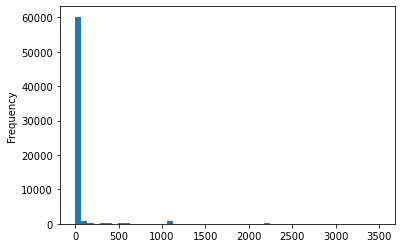

In [23]:
# Host_listings_count looks to have strange distirbution with 0 listing and 3508(!) listings 
df_airbnb.host_listings_count.plot.hist(bins=50)

It looks like there are a few outlier hosts that are registered to own over hundreds of listings (one with 3508 listings!), which are likely errors or fraud (the host may be re-posting the same property as different listings to evade regulations or to reset bad reviews) as there are nowhere near 3508 listings with this host on the current Airbnb list. <br>
It would be an interesting topic to pursue on its own, but for the purpose of this analysis, circumvent this issue by convert the listings count into categorical data for <2 listing, 2~10 listings (reference state), and 10< listings. 10 is chosen based on the quantisation by [Deboosere et al. (2019)](https://www.tandfonline.com/doi/full/10.1080/21681376.2019.1592699).

In [24]:
# Quantise the host_listings_count variable
df_airbnb['single_letting']=df_airbnb.host_listings_count.between(0,2).astype(bool)
df_airbnb['over_ten_lettings']=df_airbnb.host_listings_count.between(10,10000).astype(bool)

# Check the results
print(df_airbnb[['single_letting', 'over_ten_lettings']])
df_airbnb[['single_letting', 'over_ten_lettings']].sum()/df_airbnb['single_letting'].count()

       single_letting  over_ten_lettings
0               False              False
1                True              False
2               False               True
3               False              False
4                True              False
...               ...                ...
67897            True              False
67898            True              False
67900            True              False
67901           False              False
67902            True              False

[63454 rows x 2 columns]


single_letting       0.715999
over_ten_lettings    0.136950
dtype: float64

This shows that 72% of the listings are posted by a single owner, while half of the remaining listings are posted by hosts that have over 10 lettings on Airbnb. 

In [25]:
# Checking the currenet dataframe for Airbnb
df_airbnb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63454 entries, 0 to 67902
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   host_is_superhost    63454 non-null  bool   
 1   host_listings_count  63454 non-null  float64
 2   latitude             63454 non-null  float64
 3   longitude            63454 non-null  float64
 4   property_type        63454 non-null  object 
 5   room_type            63454 non-null  object 
 6   accommodates         63454 non-null  int64  
 7   bedrooms             63454 non-null  int64  
 8   price                63454 non-null  float64
 9   review_scores_value  44714 non-null  float64
 10  instant_bookable     63454 non-null  bool   
 11  entire_apt           63454 non-null  bool   
 12  bathrooms            63454 non-null  float64
 13  single_letting       63454 non-null  bool   
 14  over_ten_lettings    63454 non-null  bool   
dtypes: bool(5), float64(6), int64(2), ob

In [26]:
# Remove columns that are no longer needed
to_drop = ['host_listings_count', 'property_type', 'room_type']
df_airbnb.drop(columns=to_drop, inplace=True)

In [27]:
# Save the cleaned data to a folder
dest = os.path.join("data", "clean")
name = "df_airbnb_clean.csv"

save_data(df_airbnb, dest, name)

Found data/clean/df_airbnb_clean.csv locally, done!


#### e. Convert the Airbnb pandas dataframe to geopandas dataframe

In [28]:
# Convert to geopandas using longitude and latitude information of each data point
df_airbnb = gpd.GeoDataFrame(
    df_airbnb,
    geometry=gpd.points_from_xy(
        df_airbnb["longitude"], df_airbnb["latitude"], crs="epsg:4326"
    ),
)

<AxesSubplot:>

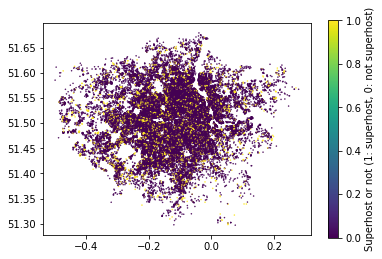

In [29]:
# Checking that the data is converted to geopandas dataframe
df_airbnb.plot(
    column="host_is_superhost",
    cmap="viridis",
    figsize=(6, 4),
    legend=True,
    legend_kwds={"label": "Superhost or not (1: superhost, 0: not superhost)"},
    markersize=0.25,
)

### 2.2 MSOA Atlas data　<a class="anchor" id="atlas"></a>　

In this subsection, MSOA Atlas data from the [Greater London Authority](https://data.london.gov.uk/dataset/msoa-atlas) published in 2014/10 is downloaded to extract median household income, unemployment rate, and percentage of white residents in each MSOA are extracted. These data are to be matched later to each Airbnb listing depending on the MSOA each listing is located, to provide locational context to the hedonic analysis.

#### a.  Load the full data to determine columns of interest

In [30]:
# Downloaded from London Datastore
url_atlas = "https://data.london.gov.uk/download/msoa-atlas/39fdd8eb-e977-4d32-85a4-f65b92f29dcb/msoa-data.xls"
dest_atlas = os.path.join("data", "raw")

# Read the full excel (1st sheet) into a dataframe
msoa_atlas_tst = pd.read_excel(download_data(url_atlas, dest_atlas), 
    sheet_name='iadatasheet1', header=[0,1,2])

Found data/raw/msoa-data.xls locally, done!


In [31]:
# Check how the data columns look like
msoa_atlas_tst.sample(5, random_state=42)

Unnamed: 0_level_0        Unnamed: 1_level_0 Age Structure (2011 Census)  \
    Unnamed: 0_level_1        Unnamed: 1_level_1                    All Ages   
             MSOA Code                 MSOA Name          Unnamed: 2_level_2   
613          E02000613  Kingston upon Thames 016                      7841.0   
451          E02000452                Harrow 020                      8218.0   
731          E02000731                Newham 018                     10073.0   
436          E02000435                Harrow 003                      7426.0   
275          E02006791                Ealing 040                      6711.0   

                                                              \
                  0-15              16-29              30-44   
    Unnamed: 3_level_2 Unnamed: 4_level_2 Unnamed: 5_level_2   
613             1545.0             1405.0             2140.0   
451             1521.0             2077.0             2476.0   
731             2184.0             3137.0             2529.0   
436             1408.0             1304.0             1561.0   
275             1082.0             1343.0             2190.0   

                                                              \
                 45-64                65+        Working-age   
    Unnamed: 6_level_2 Unnamed: 7_level_2 Unnamed: 8_level_2   
613             1688.0             1063.0             5233.0   
451             1421.0              723.0             5974.0   
731             1563.0              660.0             7229.0   
436             1767.0             1386.0             4632.0   
275             1476.0              620.0             5009.0   

    Mid-year Estimate totals  ... Road Casualties                           \
                    All Ages  ...            2010             2011           
                        2002  ...          Slight 2010 Total Fatal Serious   
613                   7510.0  ...            23.0       26.0   0.0     0.0   
451                   6379.0  ...            26.0       27.0   0.0     2.0   
731                   8135.0  ...            45.0       49.0   0.0     2.0   
436                   6420.0  ...             8.0        8.0   0.0     0.0   
275                   6506.0  ...             5.0        5.0   0.0     0.0   

                                                       
                       2012                            
    Slight 2011 Total Fatal Serious Slight 2012 Total  
613   21.0       21.0   0.0     4.0   22.0       26.0  
451   16.0       18.0   0.0     2.0   15.0       17.0  
731   36.0       38.0   1.0     7.0   44.0       52.0  
436    3.0        3.0   0.0     0.0    8.0        8.0  
275    9.0        9.0   0.0     1.0    4.0        5.0  

[5 rows x 207 columns]

In [32]:
# Finding out the top level column names
print(msoa_atlas_tst.columns.levels[0])

Index(['Adults in Employment (2011 Census)', 'Age Structure (2011 Census)',
       'Car or van availability (2011 Census)',
       'Central Heating (2011 Census)', 'Country of Birth (2011)',
       'Dwelling type (2011)', 'Economic Activity (2011 Census)',
       'Ethnic Group (2011 Census)', 'Health (2011 Census)', 'House Prices',
       'Household Composition (2011)', 'Household Income Estimates (2011/12)',
       'Household Language (2011)', 'Households (2011)', 'Incidence of Cancer',
       'Income Deprivation (2010)', 'Land Area', 'Life Expectancy',
       'Lone Parents (2011 Census)', 'Low Birth Weight Births (2007-2011)',
       'Mid-year Estimate totals', 'Mid-year Estimates 2012, by age',
       'Obesity', 'Population Density', 'Qualifications (2011 Census)',
       'Religion (2011)', 'Road Casualties', 'Tenure (2011)',
       'Unnamed: 0_level_0', 'Unnamed: 1_level_0'],
      dtype='object')


'Household Income Estimates (2011/12)', 'Economic Activity (2011 Census)', and 'Ethnic Group (2011 Census)' are what we are interested in.

#### b. Gradually drop unnecessary data to extract exact columns of interest

In [33]:
# Drop unrelated data by the top column
to_drop = ['Adults in Employment (2011 Census)', 'Age Structure (2011 Census)',
       'Car or van availability (2011 Census)',
       'Central Heating (2011 Census)', 'Country of Birth (2011)',
       'Dwelling type (2011)', 
       'Health (2011 Census)', 'House Prices',
       'Household Composition (2011)', 
       'Household Language (2011)', 'Households (2011)', 'Incidence of Cancer',
       'Income Deprivation (2010)', 'Land Area', 'Life Expectancy',
       'Lone Parents (2011 Census)', 'Low Birth Weight Births (2007-2011)',
       'Mid-year Estimate totals', 'Mid-year Estimates 2012, by age',
       'Obesity', 'Population Density', 'Qualifications (2011 Census)',
       'Religion (2011)', 'Road Casualties', 'Tenure (2011)']

msoa_atlas_tst.drop(columns=to_drop, axis=1, level=0, inplace=True)

# Check
msoa_atlas_tst.sample(5, random_state=42)

Unnamed: 0_level_0        Unnamed: 1_level_0 Ethnic Group (2011 Census)  \
    Unnamed: 0_level_1        Unnamed: 1_level_1                      White   
             MSOA Code                 MSOA Name        Unnamed: 53_level_2   
613          E02000613  Kingston upon Thames 016                     6346.0   
451          E02000452                Harrow 020                     3411.0   
731          E02000731                Newham 018                     1507.0   
436          E02000435                Harrow 003                     3933.0   
275          E02006791                Ealing 040                     5079.0   

                                                      \
    Mixed/multiple ethnic groups Asian/Asian British   
             Unnamed: 54_level_2 Unnamed: 55_level_2   
613                        316.0               832.0   
451                        376.0              3404.0   
731                        243.0              7109.0   
436                        302.0              2273.0   
275                        308.0               646.0   

                                                               \
    Black/African/Caribbean/Black British  Other ethnic group   
                      Unnamed: 56_level_2 Unnamed: 57_level_2   
613                                 213.0               134.0   
451                                 736.0               291.0   
731                                 879.0               335.0   
436                                 643.0               275.0   
275                                 508.0               170.0   

                                                                              \
                   BAME           White (%) Mixed/multiple ethnic groups (%)   
    Unnamed: 58_level_2 Unnamed: 59_level_2              Unnamed: 60_level_2   
613              1495.0           80.933554                         4.030098   
451              4807.0           41.506449                         4.575322   
731              8566.0           14.960786                         2.412390   
436              3493.0           52.962564                         4.066792   
275              1632.0           75.681717                         4.589480   

     ...                                             \
     ... Other ethnic group (%)            BAME (%)   
     ...    Unnamed: 63_level_2 Unnamed: 64_level_2   
613  ...               1.708966           19.066446   
451  ...               3.541008           58.493551   
731  ...               3.325722           85.039214   
436  ...               3.703205           47.037436   
275  ...               2.533155           24.318283   

    Economic Activity (2011 Census)                                  \
         Economically active: Total Economically active: Unemployed   
               Unnamed: 139_level_2            Unnamed: 140_level_2   
613                          4401.0                           182.0   
451                          4777.0                           327.0   
731                          4895.0                           434.0   
436                          3562.0                           240.0   
275                          4220.0                           203.0   

                                                                             \
    Economically inactive: Total Economically active %    Unemployment Rate   
            Unnamed: 141_level_2  Unnamed: 142_level_2 Unnamed: 143_level_2   
613                       1331.0             76.779484             4.135424   
451                       1594.0             74.980380             6.845300   
731                       2684.0             64.586357             8.866190   
436                       1783.0             66.641721             6.737788   
275                       1188.0             78.032544             4.810427   

                              Household Income Estimates (2011/12)  \
    Economically inactive % Total Mean Annual H

In [34]:
# Now, flatten the 3-leveled columns using a loop copied from practical 9 (credit: i2p course)

new_cols = []
for c in msoa_atlas_tst.columns.values:
    
    #print(f"Column label: {c}")
    l1 = f"{c[0]}"
    l2 = f"{c[1]}"
    l3 = f"{c[2]}"
    
    # The new column label
    clabel = ''
    
    # Assemble new label from the levels
    if not l1.startswith("Unnamed"):
        l1 = l1.replace(" (2011 Census)",'').replace(" (2011)",'').replace("Household ",'').replace("House Prices",'').replace("Car or van availability",'Vehicles').replace(' (2011/12)','')
        l1 = l1.replace('Age Structure','Age').replace("Ethnic Group",'').replace('Dwelling type','').replace('Income Estimates','')
        clabel += l1
    if not l2.startswith("Unnamed"):
        l2 = l2.replace("Numbers",'').replace(" House Price (£)",'').replace("Highest level of qualification: ",'').replace("Annual Household Income (£)",'hh Income').replace('Whole house or bungalow: ','').replace(' qualifications','')
        l2 = l2.replace('At least one person aged 16 and over in household has English as a main language',"1+ English as a main language").replace("No people in household have English as a main language","None have English as main language")
        clabel += (' - ' if clabel != '' else '') + l2
    if not l3.startswith("Unnamed"):
        clabel += (' - ' if clabel != '' else '') + l3
    
    # Replace other commonly-occuring verbiage that inflates column name width
    clabel = clabel.replace(' -  - ',' - ').replace(" household",' hh').replace('Owned: ','')
    
    #clabel = clabel.replace(' (2011 Census)','').replace(' (2011)','').replace('Sales - 2011.1','Sales - 2012')
    #clabel = clabel.replace('Numbers - ','').replace(' (£)','').replace('Car or van availability','Vehicles')
    #clabel = clabel.replace('Household Income Estimates (2011/12) - ','').replace('Age Structure','Age')
    
    new_cols.append(clabel)

print(new_cols)

['MSOA Code', 'MSOA Name', 'White', 'Mixed/multiple ethnic groups', 'Asian/Asian British', 'Black/African/Caribbean/Black British', 'Other ethnic group', 'BAME', 'White (%)', 'Mixed/multiple ethnic groups (%)', 'Asian/Asian British (%)', 'Black/African/Caribbean/Black British (%)', 'Other ethnic group (%)', 'BAME (%)', 'Economic Activity - Economically active: Total', 'Economic Activity - Economically active: Unemployed', 'Economic Activity - Economically inactive: Total', 'Economic Activity - Economically active %', 'Economic Activity - Unemployment Rate', 'Economic Activity - Economically inactive %', 'Total Mean hh Income', 'Total Median hh Income']


In [35]:
# Flatten the columns (continued)
msoa_atlas_tst.columns = new_cols
msoa_atlas_tst.head()

,MSOA Code,MSOA Name,White,Mixed/multiple ethnic groups,Asian/Asian British,Black/African/Caribbean/Black British,Other ethnic group,BAME,White (%),Mixed/multiple ethnic groups (%),...,Other ethnic group (%),BAME (%),Economic Activity - Economically active: Total,Economic Activity - Economically active: Unemployed,Economic Activity - Economically inactive: Total,Economic Activity - Economically active %,Economic Activity - Unemployment Rate,Economic Activity - Economically inactive %,Total Mean hh Income,Total Median hh Income
0,E02000001,City of London 001,5799.0,289.0,940.0,193.0,154.0,1576.0,78.630508,3.918644,...,2.088136,21.369492,4972.0,187.0,1335.0,78.833043,3.761062,21.166957,59728.481886,46788.295472
1,E02000002,Barking and Dagenham 001,4403.0,330.0,820.0,1133.0,89.0,2372.0,64.988930,4.870849,...,1.313653,35.011070,2847.0,335.0,1513.0,65.298165,11.766772,34.701835,31788.185996,27058.703760
2,E02000003,Barking and Dagenham 002,5486.0,433.0,2284.0,1618.0,224.0,4559.0,54.614236,4.310602,...,2.229965,45.385764,5038.0,459.0,2111.0,70.471395,9.110758,29.528605,43356.931547,36834.528738
3,E02000004,Barking and Dagenham 003,5006.0,186.0,313.0,649.0,28.0,1176.0,80.977030,3.008735,...,0.452928,19.022970,3187.0,296.0,1251.0,71.811627,9.287731,28.188373,46701.436554,39668.206433
4,E02000005,Barking and Dagenham 004,5674.0,313.0,1050.0,1445.0,80.0,2888.0,66.269563,3.655688,...,0.934361,33.730437,4052.0,394.0,1881.0,68.295972,9.723593,31.704028,34293.820288,29155.683536


In [36]:
# Check the remaining column names
msoa_atlas_tst.columns

Index(['MSOA Code', 'MSOA Name', 'White', 'Mixed/multiple ethnic groups',
       'Asian/Asian British', 'Black/African/Caribbean/Black British',
       'Other ethnic group', 'BAME', 'White (%)',
       'Mixed/multiple ethnic groups (%)', 'Asian/Asian British (%)',
       'Black/African/Caribbean/Black British (%)', 'Other ethnic group (%)',
       'BAME (%)', 'Economic Activity - Economically active: Total',
       'Economic Activity - Economically active: Unemployed',
       'Economic Activity - Economically inactive: Total',
       'Economic Activity - Economically active %',
       'Economic Activity - Unemployment Rate',
       'Economic Activity - Economically inactive %', 'Total Mean hh Income',
       'Total Median hh Income'],
      dtype='object')

In [37]:
# Now, extract the exact columns of interest
msoa_atlas = msoa_atlas_tst[['MSOA Code', 'MSOA Name', 'White (%)', 
                             'Economic Activity - Unemployment Rate', 'Total Median hh Income']]

White % is chosen as a diversity factor, with a reference to the work by [Deboosere et al. (2019)](https://www.tandfonline.com/doi/full/10.1080/21681376.2019.1592699), assuming that lower white % means more diverse neighbourhood. However, it would be better to look into it further, considering that there are multiple other races (Asian, Black, mixed, other) and white % only would not capture the diversity situation especially in London as opposed to NYC.

In [38]:
# Free up the capacity by deleting the full atlas data
del(msoa_atlas_tst)

In [39]:
# Check the final dataframe extracted from MSOA Atlas
msoa_atlas.sample(5, random_state=42)

,MSOA Code,MSOA Name,White (%),Economic Activity - Unemployment Rate,Total Median hh Income
613,E02000613,Kingston upon Thames 016,80.933554,4.135424,40638.630370
451,E02000452,Harrow 020,41.506449,6.845300,30719.609139
731,E02000731,Newham 018,14.960786,8.866190,25650.118968
436,E02000435,Harrow 003,52.962564,6.737788,32216.945440
275,E02006791,Ealing 040,75.681717,4.810427,48508.388576


In [40]:
# Save the selected MSOA Atlas data to a folder
dest = os.path.join("data", "clean")
name = "msoa_atlas_clean.csv"

save_data(msoa_atlas, dest, name)

data/clean/msoa_atlas_clean.csv not found, saving...
	Done saving.


### 2.3 MSOA and London borough boundary data <a class="anchor" id="boundary"></a>

To assist the combination of Airbnb and MSOA demographic data as well as to enable mapped output, download MSOA and London borough boundary data from [Office for National Statistics saved by John Reads](https://github.com/jreades/i2p/blob/master/data/src).

#### a. Load MSOA and London borough boundary data

data/raw/Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2-shp.zip not found, downloading...
	Done downloading.


<AxesSubplot:>

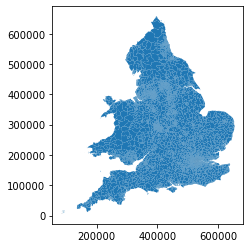

In [41]:
# Downloading MSOA boundary data to the local folder

url_msoa = 'https://github.com/neneninja97/FSDS_Submission/blob/main/Data/Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2-shp.zip?raw=true'
dest_msoa = os.path.join("data", "raw")

msoas = gpd.read_file(download_data(url_msoa, dest_msoa))

#check the data by plotting
msoas.plot()

data/raw/Boroughs.gpkg not found, downloading...
	Done downloading.


/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


<AxesSubplot:>

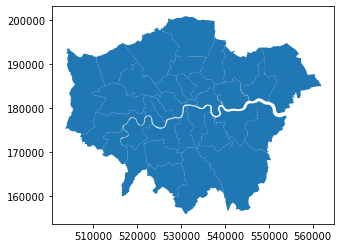

In [42]:
# Downloading London borough boundary data to the local folder

url_borough = 'https://github.com/neneninja97/FSDS_Submission/blob/main/Data/Boroughs.gpkg?raw=true'
dest_borough = os.path.join("data", "raw")

borough = gpd.read_file(download_data(url_borough, dest_borough))

#check the data by plotting
borough.plot()

#### b. Extract the MSOAs within London boroughs

,original,geometry
0,"POLYGON ((534747.800 159517.800, 534588.000 15...","POLYGON ((503325.036 175328.990, 503324.758 17..."


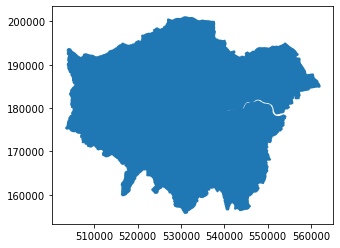

In [43]:
# Extracting the outline of London
ldn = gpd.GeoDataFrame(gpd.GeoSeries(data=borough.unary_union, crs='epsg:27700')).rename(columns={0:'original'})
ldn['geometry'] = ldn.original.buffer(250) # Give 250 m of buffer
ldn = ldn.set_geometry('geometry')
ldn.plot();

ldn

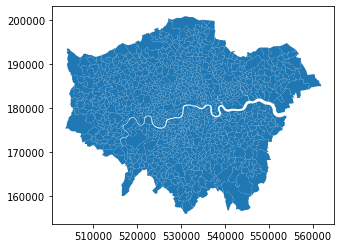

In [44]:
# Extract MSOAs within the outer boundary of London 
ldn_msoas = gpd.sjoin(msoas, ldn, op='within')   # default: inner join
ldn_msoas.plot();

del(msoas)  # delete the remaining msoas data to free up the capacity

In [45]:
# Check the dataframe
ldn_msoas.sample(3)

,OBJECTID,MSOA11CD,MSOA11NM,MSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,geometry,index_right,original
208,209,E02000215,Croydon 022,Croydon 022,533518,166180,-0.08287,51.37897,981649.474472,5013.551157,"POLYGON ((533191.303 166823.484, 533231.976 16...",0,"POLYGON ((534747.800 159517.800, 534588.000 15..."
415,416,E02000431,Haringey 035,Haringey 035,528891,187694,-0.14148,51.57339,610248.577042,3459.269797,"POLYGON ((528473.863 188166.973, 528664.000 18...",0,"POLYGON ((534747.800 159517.800, 534588.000 15..."
337,338,E02000352,Hackney 008,Hackney 008,532794,186553,-0.08562,51.56223,760901.997566,6469.721064,"POLYGON ((533027.442 187174.386, 533047.396 18...",0,"POLYGON ((534747.800 159517.800, 534588.000 15..."


In [46]:
ldn_msoas.columns

Index(['OBJECTID', 'MSOA11CD', 'MSOA11NM', 'MSOA11NMW', 'BNG_E', 'BNG_N',
       'LONG', 'LAT', 'Shape__Are', 'Shape__Len', 'geometry', 'index_right',
       'original'],
      dtype='object')

In [47]:
# Remove columns that are not necessary
to_drop = ['OBJECTID', 'MSOA11NM', 'MSOA11NMW', 'BNG_E', 'BNG_N',
       'LONG', 'LAT', 'Shape__Len', 'index_right',
       'original']

ldn_msoas.drop(columns=to_drop, inplace=True)

In [48]:
# Save the cleaned data to a folder
ldn_msoas.to_file(os.path.join('data','clean','London_MSOAs.gpkg'), driver='GPKG')

### 2.4 Combining 3 datasets together <a class="anchor" id="combine"></a>

Finally, we will combine Airbnb data (from 2.1) and MSOA atlas data (from 2.2) by making use of London MSOA boundary data (from 2.3) loaded and cleaned separately above.

#### a. Add geometry to the MSOA atlas data by matching the MSOA code

In [49]:
# Inspecting ldn_msoas
print(ldn_msoas.shape)
ldn_msoas.sample(2, random_state = 42)

(983, 3)


,MSOA11CD,Shape__Are,geometry
810,E02000841,1.155722e+06,"POLYGON ((526809.139 166761.960, 526815.439 16..."
801,E02000832,8.444512e+05,"POLYGON ((535382.233 176270.453, 535479.898 17..."


In [50]:
# Inspecting msoa_atlas
print(msoa_atlas.shape) # one more entry than ldn_msoas boundary data due to the 'total' entry
msoa_atlas.sample(5, random_state = 42)

(984, 5)


,MSOA Code,MSOA Name,White (%),Economic Activity - Unemployment Rate,Total Median hh Income
613,E02000613,Kingston upon Thames 016,80.933554,4.135424,40638.630370
451,E02000452,Harrow 020,41.506449,6.845300,30719.609139
731,E02000731,Newham 018,14.960786,8.866190,25650.118968
436,E02000435,Harrow 003,52.962564,6.737788,32216.945440
275,E02006791,Ealing 040,75.681717,4.810427,48508.388576


It looks that 'MSOA11CD' from ldn_msoas and 'MSOA Code' from msoa_atlas can be matched to combine these two data:

In [51]:
# Join MSOA atlas and boundary data
msoa_merged = pd.merge(ldn_msoas, msoa_atlas, left_on='MSOA11CD', right_on='MSOA Code', how='inner')
msoa_merged.drop(columns='MSOA11CD', inplace=True)

# Rename columns
msoa_merged = msoa_merged.rename(columns={'White (%)': 'white_perc', 
                        'Economic Activity - Unemployment Rate': 'unemployment_rate', 
                        'Total Median hh Income': 'median_income'})


# checking the merged data
print(msoa_merged.shape)
print(type(msoa_merged))
msoa_merged.sample(2, random_state=42)

(983, 7)
<class 'geopandas.geodataframe.GeoDataFrame'>


,Shape__Are,geometry,MSOA Code,MSOA Name,white_perc,unemployment_rate,median_income
810,1.155722e+06,"POLYGON ((526809.139 166761.960, 526815.439 16...",E02000841,Sutton 002,72.743951,8.485523,23551.820809
801,8.444512e+05,"POLYGON ((535382.233 176270.453, 535479.898 17...",E02000832,Southwark 026,43.995984,9.157148,26730.054694


#### b. Match MSOA-wide demographic information from (a) to each Airbnb listing

In [52]:
# inspect the airbnb data to check the CRS (MSOA data is in British National Grid)
df_airbnb.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 63454 entries, 0 to 67902
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   host_is_superhost    63454 non-null  bool    
 1   latitude             63454 non-null  float64 
 2   longitude            63454 non-null  float64 
 3   accommodates         63454 non-null  int64   
 4   bedrooms             63454 non-null  int64   
 5   price                63454 non-null  float64 
 6   review_scores_value  44714 non-null  float64 
 7   instant_bookable     63454 non-null  bool    
 8   entire_apt           63454 non-null  bool    
 9   bathrooms            63454 non-null  float64 
 10  single_letting       63454 non-null  bool    
 11  over_ten_lettings    63454 non-null  bool    
 12  geometry             63454 non-null  geometry
dtypes: bool(5), float64(5), geometry(1), int64(2)
memory usage: 4.7 MB


In [53]:
# Transform the crs to British National Grid (EPSG: 27700)
df_airbnb.to_crs("EPSG:27700", inplace = True)

In [54]:
# Match these two data using spatial join
df_final = gpd.sjoin(df_airbnb, msoa_merged, op='within', how='left') # op options: intersect, within, contains

# checking the combined data
df_final.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 63454 entries, 0 to 67902
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   host_is_superhost    63454 non-null  bool    
 1   latitude             63454 non-null  float64 
 2   longitude            63454 non-null  float64 
 3   accommodates         63454 non-null  int64   
 4   bedrooms             63454 non-null  int64   
 5   price                63454 non-null  float64 
 6   review_scores_value  44714 non-null  float64 
 7   instant_bookable     63454 non-null  bool    
 8   entire_apt           63454 non-null  bool    
 9   bathrooms            63454 non-null  float64 
 10  single_letting       63454 non-null  bool    
 11  over_ten_lettings    63454 non-null  bool    
 12  geometry             63454 non-null  geometry
 13  index_right          63432 non-null  float64 
 14  Shape__Are           63432 non-null  float64 
 15  MSOA Code  

#### c. Drop datapoints with missing MSOA data

<AxesSubplot:>

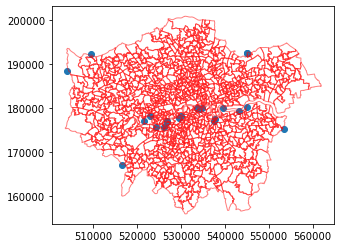

In [55]:
### c. Drop datapoints with potential errors ###

# Investigate why some MSOA data did not match (22 entries)
# Map those entries
ax = df_final[df_final['MSOA Code'].isna()].plot()
ldn_msoas.plot(ax=ax, edgecolor='r', facecolor='None', alpha=0.5)

It looks to be that the Airbnb entries with missing MSOA data are near the edge of the MSOA boundaries. It is likely that the scraped latitude and longitude of these data are slightly shifted to protect their exact location by Airbnb. As the number of these data are small (less than 0.05%), so proceed the analyses without these data points.

In [56]:
df_final.drop(index = df_final[df_final['MSOA Code'].isna()].index.values, axis='rows', inplace=True)
df_final.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 63432 entries, 0 to 67902
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   host_is_superhost    63432 non-null  bool    
 1   latitude             63432 non-null  float64 
 2   longitude            63432 non-null  float64 
 3   accommodates         63432 non-null  int64   
 4   bedrooms             63432 non-null  int64   
 5   price                63432 non-null  float64 
 6   review_scores_value  44701 non-null  float64 
 7   instant_bookable     63432 non-null  bool    
 8   entire_apt           63432 non-null  bool    
 9   bathrooms            63432 non-null  float64 
 10  single_letting       63432 non-null  bool    
 11  over_ten_lettings    63432 non-null  bool    
 12  geometry             63432 non-null  geometry
 13  index_right          63432 non-null  float64 
 14  Shape__Are           63432 non-null  float64 
 15  MSOA Code  

In [57]:
# Remove columns that are no longer needed

to_drop = ['latitude', 'longitude', 'index_right']
df_final.drop(columns=to_drop, axis = 1, inplace=True)

In [58]:
# Look into summary statistics
df_final.describe(percentiles=[0.01, 0.99])

,accommodates,bedrooms,price,review_scores_value,bathrooms,Shape__Are,white_perc,unemployment_rate,median_income
count,63432.000000,63432.000000,63432.000000,44701.000000,63432.000000,6.343200e+04,63432.000000,63432.000000,63432.000000
mean,3.073543,1.488555,138.718975,4.641528,1.320469,1.063218e+06,60.578503,7.355707,38189.863211
std,1.953923,0.878411,289.096476,0.518193,0.619245,1.140838e+06,14.817757,2.752913,12023.164664
min,1.000000,1.000000,1.000000,0.000000,0.000000,2.939242e+05,6.135602,2.510176,17877.688341
1%,1.000000,1.000000,19.000000,2.000000,1.000000,3.358270e+05,23.732766,2.835788,20825.049968
50%,2.000000,1.000000,82.000000,4.780000,1.000000,7.558931e+05,62.634082,7.008803,35630.365498
99%,10.000000,5.000000,1200.000000,5.000000,3.500000,4.330306e+06,88.582330,14.444444,72851.394919
max,16.000000,22.000000,18012.000000,5.000000,21.000000,2.244844e+07,96.187683,17.392718,89999.489787


In [59]:
# Look into summary statistics
df_final.describe(percentiles=[0.01, 0.99])

,accommodates,bedrooms,price,review_scores_value,bathrooms,Shape__Are,white_perc,unemployment_rate,median_income
count,63432.000000,63432.000000,63432.000000,44701.000000,63432.000000,6.343200e+04,63432.000000,63432.000000,63432.000000
mean,3.073543,1.488555,138.718975,4.641528,1.320469,1.063218e+06,60.578503,7.355707,38189.863211
std,1.953923,0.878411,289.096476,0.518193,0.619245,1.140838e+06,14.817757,2.752913,12023.164664
min,1.000000,1.000000,1.000000,0.000000,0.000000,2.939242e+05,6.135602,2.510176,17877.688341
1%,1.000000,1.000000,19.000000,2.000000,1.000000,3.358270e+05,23.732766,2.835788,20825.049968
50%,2.000000,1.000000,82.000000,4.780000,1.000000,7.558931e+05,62.634082,7.008803,35630.365498
99%,10.000000,5.000000,1200.000000,5.000000,3.500000,4.330306e+06,88.582330,14.444444,72851.394919
max,16.000000,22.000000,18012.000000,5.000000,21.000000,2.244844e+07,96.187683,17.392718,89999.489787


In [60]:
# Save the final dataframe ready for analyses
dest = os.path.join("data", "final")
name = 'airbnb_MSOAs.csv'
save_data(df_final, dest, name) # as csv

data/final/airbnb_MSOAs.csv not found, saving...
	Done saving.


## 3. Investigating target and explanatory variables <a class="anchor" id="third"></a>

Before conducting hedonic regression analysis, each variables under investitation should be explored to understand the distribution of these variables. To summarise the current progress, below variables are prepared in the df_final dataframe: <br>
<br>
[For hedonic analysis]
- Target variable: 'price' \<float>
- Explanatory variables (property): 'accommodates' \<int>, 'bathrooms' \<float>, 'bedrooms' \<int>
- Explanatory variables (host): 'host_is_superhost' \<bool>, 'instant_bookable' \<bool>, 'single_letting' \<bool>, 'over_ten_lettings' \<bool>
- Explanatory variables (location): 'white_perc' \<float>, 'unemployment_rate' \<float>, 'median_income' \<float>　 <br>

[Supporting variables]
- Supporting variable for target variable: 'review_scores_value'
- Supporting variable for mapping: 'geometry', 'MSOA Code', 'MSOA Name' 'Shape__Are'

### 3.1 Descriptive statistics of original variables

To understand how each variable is distributed, this section investigates the distribution of the variables. This is done for target and supporting variables (a), numerical (float and int) explanatory variables (b), and boolean explanatory variables (c).

In [61]:
# Here is the list of target/ explanatory variables that will be investigated
target = ['price'] # float
cont = ['white_perc','unemployment_rate', 'median_income'] # float
disc = ['accommodates', 'bathrooms', 'bedrooms'] # int
categ = ['entire_apt', 'host_is_superhost', 'instant_bookable', 'single_letting', 'over_ten_lettings'] # boolean

#### a. Target variable (price, review scores for value)

Check how the letting pries are distributed both numerically and spatially

<AxesSubplot:>

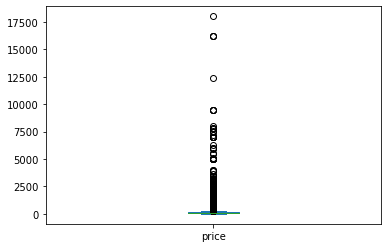

In [62]:
# Histogram
df_final.price.plot.box()

It shows that price is so highly skewed - shows a very significant disparity betwen listings. For the hedonic analysis, this variable will need to be log transformed so that a few very expensive listings will not dominate the analysis.

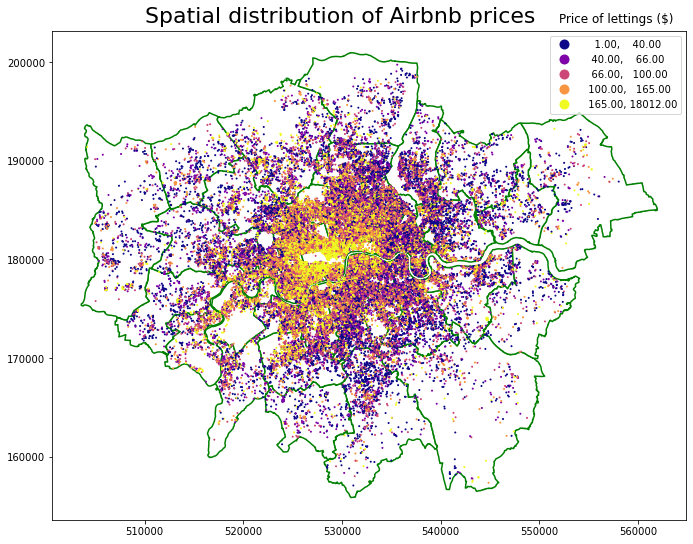

In [63]:
# Mapping price distribution

plot, ax = plt.subplots(1,1, figsize=(12,9))

# Plot borough outline and the price distributino on the same map
borough.plot(ax=ax, edgecolor = "green", facecolor = "white", linewidth = 1.5)
df_final.plot(ax=ax, column='price', cmap='plasma', scheme='quantiles', k=5, markersize=1,
                legend = True)
ax.text(x = 552000, y = 204000, s = 'Price of lettings ($)', size = 12) # title
ax.text(x = 510000, y = 204000, s = 'Spatial distribution of Airbnb prices', size = 22) # legend

fig = plot.get_figure()
os.makedirs('output', exist_ok=True)
fig.savefig(os.path.join('output','price_map.jpg'))

More expensive properties are located near the center as expected, but it is unclear yet, to what extent it is due to the location factors and due to other factors such as more 'entire-apt' are rented in the center, for exmple.

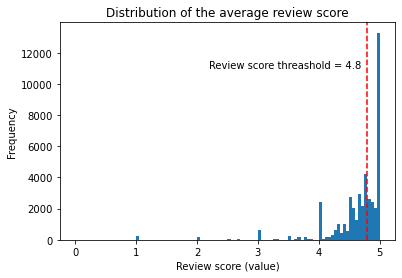

In [64]:
#### Review score - how good the value is to price

#create a base plot
fig, ax = plt.subplots(1,1, figsize = (6,4))

#create the histograme for the plot
ax.hist(x = df_final["review_scores_value"], bins = 100)

# Vertical line showing the threashold
ax.axvline(x = 4.8, color = "red", linestyle = "--")
ax.text(x = 2.2, y = 11000, s = f"Review score threashold = 4.8")

# Histogram title and axes
ax.set_title("Distribution of the average review score")
ax.set_xlabel("Review score (value)")
ax.set_ylabel("Frequency")

# Save
fig.savefig(os.path.join('output','review_dist.jpg'))

This shows that most reviews on pricing are ranged within 4 and 5. Considering that the rating required to make a superhost is 4.8 or above, use this criteria for the second set of hedonic analysis that will be done only for the 'righly priced Airbnb listings'.

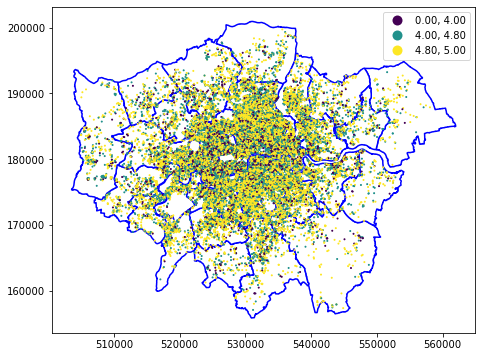

In [65]:
# Check the distribution of the review scores

plot, ax = plt.subplots(1,1, figsize=(8,6))

# Plot borough outline and the price distributino on the same map
borough.plot(ax=ax, edgecolor = "blue", facecolor = "white", linewidth = 1.5)
df_final.plot(ax=ax, column='review_scores_value', cmap='viridis', scheme= 'user_defined', 
              classification_kwds={'bins':[4.0, 4.8, 5.0]},
              legend = True, markersize = 1)
fig = plot.get_figure()

fig.savefig(os.path.join('output','review_map.jpg'))

It looks like the review scores are quite evenly distributed, except maybe for in the central area, where there may be more lower reviews indicating overpriced listings for the value.

#### b. Numerical explanatory variables

Now invesrigate the float explanatory variables, which happen to be the 3 location variables.

In [66]:
df_final[cont].describe()

,white_perc,unemployment_rate,median_income
count,63432.000000,63432.000000,63432.000000
mean,60.578503,7.355707,38189.863211
std,14.817757,2.752913,12023.164664
min,6.135602,2.510176,17877.688341
25%,50.098769,5.277848,28685.076547
50%,62.634082,7.008803,35630.365498
75%,70.944077,9.158843,46013.127533
max,96.187683,17.392718,89999.489787


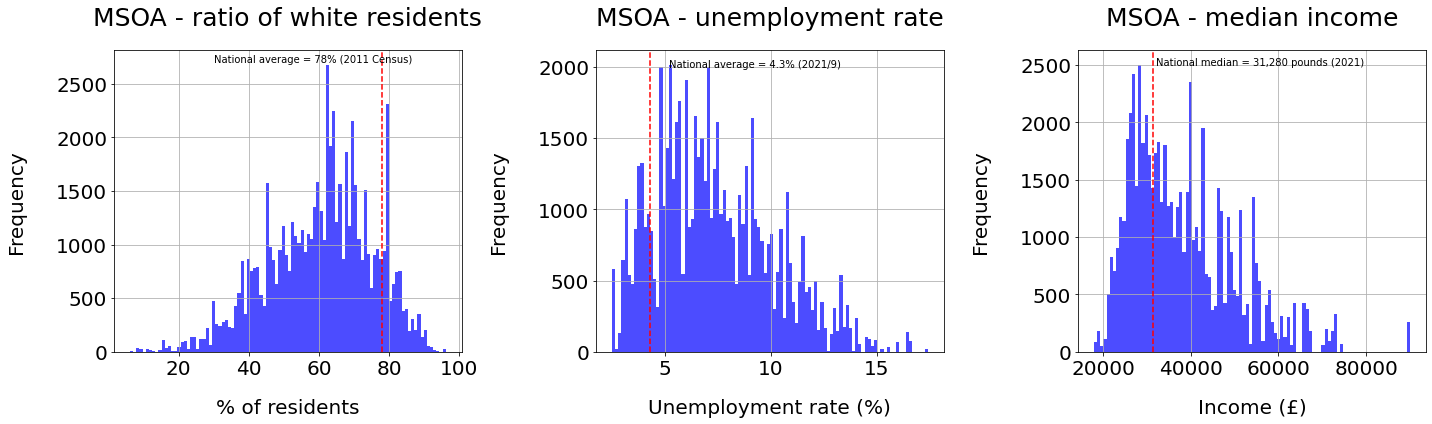

In [67]:
# Plot the distribution on histograms - code adapted from Phillip's 

#set the histogram titles
hist_titles = ["MSOA - ratio of white residents",
              "MSOA - unemployment rate",
              "MSOA - median income"]

#set the axis labels
axis_labels = ["% of residents",
              "Unemployment rate (%)",
              "Income (£)"]

#create a base axis for the plots
fig, ax = plt.subplots(1,3, figsize = (20,6))
#flatten the axis to make it easy to iteratre over
axis = ax.flatten()

###iterate over each columns using the labels information already set up###
for i, col in enumerate(cont):

    #create the histogram using the column
    df_final[col].hist(bins = 100, ax = axis[i],
                                       color = "blue",
                                       alpha = 0.7)
    #add label information
    axis[i].set_title(hist_titles[i], fontsize = 25, pad = 25)
    axis[i].set_ylabel("Frequency", fontsize  =20, labelpad = 30)
    axis[i].set_xlabel(f"{axis_labels[i]}", fontsize = 20, labelpad = 20)
    axis[i].tick_params(axis = "both", labelsize = 20) 
    
### Add vertical lines for the national average###  

# Data for national average from: GOV.UK ethnicity figures and facts
# https://www.ethnicity-facts-figures.service.gov.uk/#:~:text=Government%20data%20about%20the%20UK's,group%20(2011%20Census%20data).
axis[0].axvline(x = 78, color = "red", linestyle = "--")
axis[0].text(x = 30, y = 2700, s = f"National average = 78% (2011 Census)")

# Data for national average from: ONS
# https://www.ons.gov.uk/employmentandlabourmarket/peopleinwork/employmentandemployeetypes/bulletins/employmentintheuk/november2021
axis[1].axvline(x = 4.3, color = "red", linestyle = "--")
axis[1].text(x = 5.2, y = 2000, s = f"National average = 4.3% (2021/9)")

# Data for national average from: Statista
# https://www.statista.com/statistics/1002964/average-full-time-annual-earnings-in-the-uk/#:~:text=The%20median%20annual%20earnings%20for,increase%20of%2013.48%20thousand%20pounds.
axis[2].axvline(x = 31280, color = "red", linestyle = "--")
axis[2].text(x = 32000, y = 2500, s = f"National median = 31,280 pounds (2021)")
    
#remove the unused axis
#axis[3].set_axis_off()
#keep the layout tight
plt.tight_layout()
#show the plot 
plt.show()

fig.savefig(os.path.join('output','cont_hist.jpg'))

There are some skews to the distributions, especially the unemployment rate and the median income. They should be log-transformed before hedonic analysis (section 4.1).

Now plot the integer variables, which all happen to be the property explanatory variables:

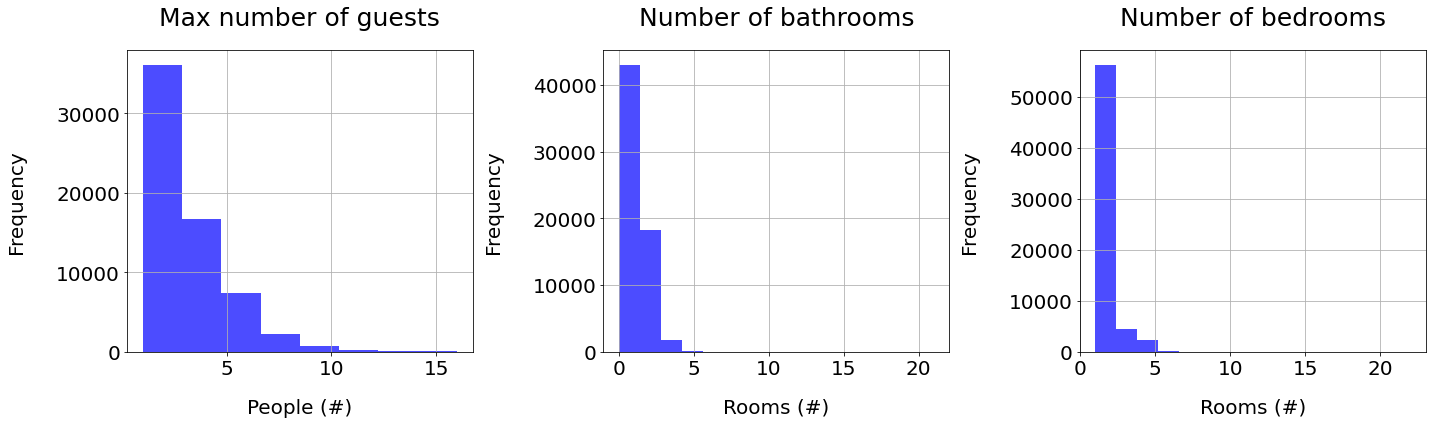

In [68]:
# Plot the distribution on histograms - code adapted from Phillip's 

#set the histogram titles
hist_titles = ["Max number of guests",
              "Number of bathrooms",
              "Number of bedrooms"]

#set the axis labels
axis_labels = ["People (#)",
              "Rooms (#)",
              "Rooms (#)"]

#create a base axis for the plots
fig, ax = plt.subplots(1,3, figsize = (20,6))
#flatten the axis to make it easy to iteratre over
axis = ax.flatten()

#iterate over each columns using the labels information already set up
for i, col in enumerate(disc):
    
    #add label information
    axis[i].set_title(hist_titles[i], fontsize = 25, pad = 25)
    axis[i].set_ylabel("Frequency", fontsize  =20, labelpad = 30)
    axis[i].set_xlabel(f"{axis_labels[i]}", fontsize = 20, labelpad = 20)
    axis[i].tick_params(axis = "both", labelsize = 20)
    
    # Set bin width separately for max number of guests and the rest
    if i == 0:
        #create the histogram using the column
        df_final[col].hist(bins = 8, ax = axis[i],
                                           color = "blue",
                                           alpha = 0.7)
    else:
        #create the histogram using the column
        df_final[col].hist(bins = 15, ax = axis[i],
                                           color = "blue",
                                           alpha = 0.7)
    
#remove the unused axis
#axis[3].set_axis_off()
#keep the layout tight
plt.tight_layout()
#show the plot 
plt.show()

fig.savefig(os.path.join('output','disc_hist.jpg'))

Int variables (max number of guests, number of bedrooms, and number of bathrooms) are highly skewed, but quantisation like host_listings_cound would not work for these variables due to a significant difference in price (target variable) for different number of bedrooms/ bathrooms/ guests, and log/ power transformation would not be suitable for these distributions either. Consider fitting distributions such as poisson and transforming in the future, but for the purpose of this analysis, leave these variables as they are.

#### c. Bool explanatory variables

Finally, investigate the boolean variables:

In [69]:
# Find the ratio of 'True' entries
df_final[categ].sum()/df_final['MSOA Name'].count()

entire_apt           0.546254
host_is_superhost    0.139977
instant_bookable     0.327280
single_letting       0.715948
over_ten_lettings    0.136997
dtype: float64

### 3.2 Transform skewed float variables

As identified in 3.1, listing price, unemployment rate, and median income are highly skewed float variables, so take natural log of these variables for the hedonic analysis.

#### a. Take natural log for some of the continuous variables

In [70]:
# Before this step, create a dataframe specifically for the hedonic analysis
df_hedonic = df_final.copy()

In [71]:
# To make sure where is no zero in the data, check the stats
df_hedonic[cont].describe()

,white_perc,unemployment_rate,median_income
count,63432.000000,63432.000000,63432.000000
mean,60.578503,7.355707,38189.863211
std,14.817757,2.752913,12023.164664
min,6.135602,2.510176,17877.688341
25%,50.098769,5.277848,28685.076547
50%,62.634082,7.008803,35630.365498
75%,70.944077,9.158843,46013.127533
max,96.187683,17.392718,89999.489787


In [72]:
# Take log for all 4 for now
transform = target + cont
ln_cont = []

for i in transform:  
    ln_cont.append('ln_'+i)  # Compiling the list of ln_ variable names at the same time
    df_hedonic['ln_'+i]=np.log(df_hedonic[i])

In [73]:
# Drop unnecessary columns for the hedonic analysis
to_drop = ['price', 'Shape__Are', 'MSOA Code', 'MSOA Name', 'ln_white_perc', 'review_scores_value',
           'unemployment_rate', 'median_income']

df_hedonic.drop(columns=to_drop, inplace=True)
df_hedonic.columns

Index(['host_is_superhost', 'accommodates', 'bedrooms', 'instant_bookable',
       'entire_apt', 'bathrooms', 'single_letting', 'over_ten_lettings',
       'geometry', 'white_perc', 'ln_price', 'ln_unemployment_rate',
       'ln_median_income'],
      dtype='object')

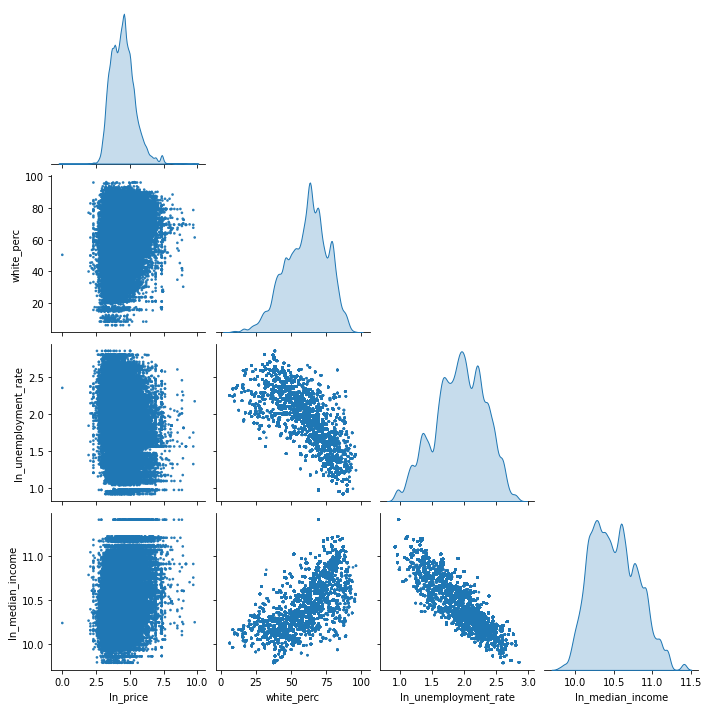

In [74]:
# Plot the dataset to be standardised for the hedonic analysis
cont_fin = ['ln_price',
 'white_perc',
 'ln_unemployment_rate',
 'ln_median_income']

# Sets some handy 'keywords' to tweak the Seaborn plot
kwds = dict(s=7,alpha=0.95,edgecolor="none")

# plot
fig = sns.pairplot(data=df_hedonic[cont_fin],diag_kind='kde', corner=True, plot_kws=kwds);
fig.savefig(os.path.join('output','cont_scatter.jpg'))

The price does not look very well-correlated to the explanatory variables from this chart, while explanatory vraiebles may have correlation between themselves. This may cause an issue, so use VIF to ensure there is not multicollinearity before running the hedonic analysis in Section 4.

In [75]:
# Save the final dataframe for heconic analysis
dest = os.path.join("data", "final")
name = 'hedonic_variables.csv'
save_data(df_hedonic, dest, name) # as csv

data/final/hedonic_variables.csv not found, saving...
	Done saving.


## 4. Hedonic analysis of Airbnb listing prices <a class="anchor" id="fourth"></a>

Finally, using the prepared data, we will run a multiple linear regression analysis to find out which elements have important impact on the listing prices. To allow comparison of coefficients magnitudes, we will standardise all variables using MinMaxScaler <x/(xmax-xmin)>. We will run two sets of regression analysis, one for all data points and the other for data points with review scores above 4.8 (which is the review score threashold [Airbnb uses to recognise superhosts](https://www.airbnb.co.uk/help/article/829/how-to-become-a-superhost)). <br>
<br>
Final variables to be used in the analyses are:
- Target variable: 'ln_price' \<float>
- Explanatory variables (property): 'accommodates' \<int>, 'bathrooms' \<float>, 'bedrooms' \<int>
- Explanatory variables (host): 'host_is_superhost' \<bool>, 'instant_bookable' \<bool>, 'single_letting' \<bool>, 'over_ten_lettings' \<bool>
- Explanatory variables (location): 'white_perc' \<float>, 'ln_unemployment_rate' \<float>, 'ln_median_income' \<float> <br>

Note that white_perc is a proxy for a diversity of the neighbourhood, used also in [Deboosere et al. (2019)](https://www.tandfonline.com/doi/full/10.1080/21681376.2019.1592699)

### 4.1 Standardising variables for hedonic regression analysis

In [76]:
# Drop geometry from df_hedonic

df_hedonic = pd.DataFrame(df_hedonic.drop(columns='geometry'))

In [77]:
# Standardise using MinMaxScaler - bool value will not be affected by this
mms = MinMaxScaler(feature_range=(-1,1))        # Initialise
#rbs = RobustScaler(quantile_range=[0.05,0.95]) # Alternative

# Rescale
for c in df_hedonic.columns:
    df_hedonic[c] = mms.fit_transform(df_hedonic[c].values.reshape(-1,1))
    
# Check
df_hedonic.head(3)

,host_is_superhost,accommodates,bedrooms,instant_bookable,entire_apt,bathrooms,single_letting,over_ten_lettings,white_perc,ln_price,ln_unemployment_rate,ln_median_income
0,-1.0,-0.866667,-1.000000,-1.0,-1.0,-0.904762,-1.0,-1.0,0.334593,-0.147979,0.164241,-0.206496
1,-1.0,-0.866667,-1.000000,-1.0,1.0,-0.904762,1.0,-1.0,0.704162,-0.118771,-0.488448,0.461553
2,-1.0,-0.333333,-0.809524,-1.0,1.0,-0.809524,-1.0,1.0,0.362125,0.168888,-0.141712,0.088968


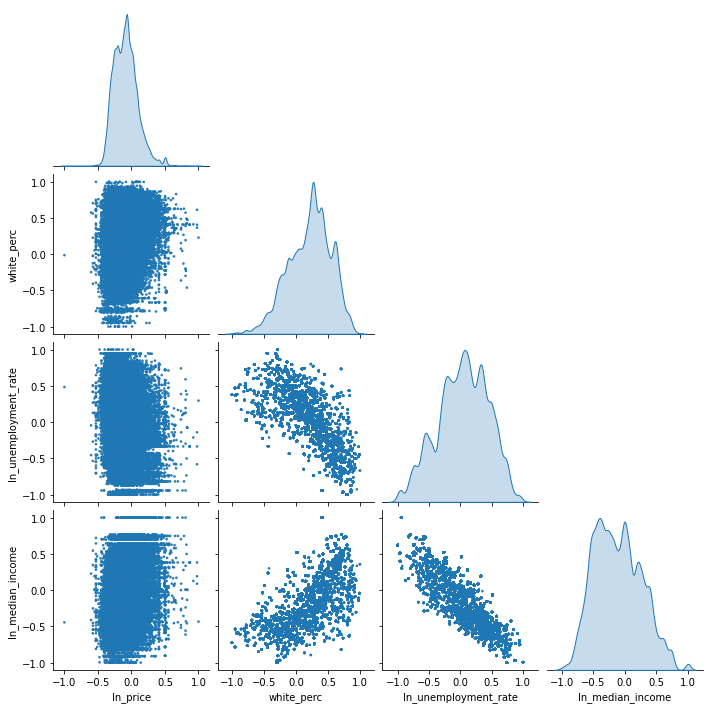

In [78]:
# Plot to check
sns.pairplot(data=df_hedonic[cont_fin],diag_kind='kde', corner=True, plot_kws=kwds);

In [79]:
df_hedonic.describe()

,host_is_superhost,accommodates,bedrooms,instant_bookable,entire_apt,bathrooms,single_letting,over_ten_lettings,white_perc,ln_price,ln_unemployment_rate,ln_median_income
count,63432.000000,63432.000000,63432.000000,63432.000000,63432.000000,63432.000000,63432.000000,63432.000000,63432.000000,63432.000000,63432.000000,63432.000000
mean,-0.720047,-0.723528,-0.953471,-0.345441,0.092509,-0.874241,0.431896,-0.726006,0.209143,-0.090126,0.036559,-0.117388
std,0.693931,0.260523,0.083658,0.938448,0.995720,0.058976,0.901931,0.687694,0.329093,0.175231,0.398809,0.369547
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-0.866667,-1.000000,-1.000000,-1.000000,-0.904762,-1.000000,-1.000000,-0.023606,-0.223034,-0.232148,-0.414913
50%,-1.000000,-0.866667,-1.000000,-1.000000,1.000000,-0.904762,1.000000,-1.000000,0.254796,-0.100559,0.060923,-0.146612
75%,-1.000000,-0.600000,-0.904762,1.000000,1.000000,-0.857143,1.000000,-1.000000,0.439355,0.015785,0.337364,0.169835
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 4.2 Hedonic regression analysis

Before running the analysis, check that the explanatory variables are not strongly correlated with each other using the VIF method, and drop variables if need be:

In [80]:
# VIF to check that no explanatory variables are correlated too closely

# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568 - by CASA0007 QM module
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant
def drop_column_using_vif_(df, thresh=10):
    while True:
        # adding a constant item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

df_hedonic_VIF = drop_column_using_vif_(df_hedonic.drop('ln_price', axis=1))
df_hedonic_VIF.columns

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Index(['host_is_superhost', 'accommodates', 'bedrooms', 'instant_bookable',
       'entire_apt', 'bathrooms', 'single_letting', 'over_ten_lettings',
       'white_perc', 'ln_unemployment_rate', 'ln_median_income'],
      dtype='object')

Run the model:

In [81]:
# Build multiple linear regression from stats model

regression_result = sm.OLS(endog=df_hedonic[['ln_price']], exog=sm.add_constant(df_hedonic_VIF)).fit()
regression_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     6437.
Date:                Sun, 09 Jan 2022   Prob (F-statistic):               0.00
Time:                        18:20:46   Log-Likelihood:                 44250.
No. Observations:               63432   AIC:                        -8.848e+04
Df Residuals:                   63420   BIC:                        -8.837e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.4059      0.009     44.553      0.000       0.388       0.424
host_is_superhost       -0.0025      0.001     -3.549      0.000      -0.004      -0.001
accommodates             0.1421      0.003     40.978      0.000       0.135       0.149
bedrooms                 0.2257      0.011     20.933      0.000       0.205       0.247
instant_bookable         0.0025      0.001      4.762      0.000       0.001       0.003
entire_apt               0.0624      0.001    104.842      0.000       0.061       0.064
bathrooms                0.1614      0.010     15.385      0.000       0.141       0.182
single_letting          -0.0111      0.001    -15.922      0.000      -0.012      -0.010
over_ten_lettings        0.0426      0.001     46.460      0.000       0.041       0.044
white_perc               0.0062      0.002      2.661      0.008       0.002       0.011
ln_unemployment_rate     0.0095      0.003      3.517      0.000       0.004       0.015
ln_median_income         0.0806      0.003     30.311      0.000       0.075       0.086
==============================================================================
Omnibus:                    23809.428   Durbin-Watson:                   1.588
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           196129.620
Skew:                           1.585   Prob(JB):                         0.00
Kurtosis:                      11.010   Cond. No.                         59.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 4.3 Hedonic regression analysis for 'appropriately priced' listings

As shown in Section 3.3b, some listigs especially around the center are receiving low value score by vistors, which may indicate ill-priced listings. To remove the impact of these listings on the model, re-run the multiple regression model only with datapoints with review score > 4.8.

In [82]:
# Create a new dataframe for this analysis
df_hedonic_2 = df_hedonic.copy()

In [83]:
# Merge review_scores_value from df_final
df_hedonic_2['review_scores_value']= df_final['review_scores_value']

In [84]:
# Filter using 'review_scores_value' >= 4.8
df_hedonic_2 = df_hedonic_2[df_hedonic_2['review_scores_value']>=4.8]

In [85]:
# Drop the review score column now for the regression analysis
# Drop unnecessary columns for the hedonic analysis
to_drop = ['review_scores_value']

df_hedonic_2.drop(columns=to_drop, inplace=True)
df_hedonic_2.columns

Index(['host_is_superhost', 'accommodates', 'bedrooms', 'instant_bookable',
       'entire_apt', 'bathrooms', 'single_letting', 'over_ten_lettings',
       'white_perc', 'ln_price', 'ln_unemployment_rate', 'ln_median_income'],
      dtype='object')

In [86]:
# Check the number of datapoints remaining
print(df_hedonic.shape)   # original data from hedonic analysis in Section 4.2
print(df_hedonic_2.shape) # new data only with value review > 4.8

(63432, 12)
(21463, 12)


In [87]:
# Now run the regression analysis

regression_result_2 = sm.OLS(endog=df_hedonic_2[['ln_price']], 
                             exog=sm.add_constant(df_hedonic_2.drop(columns = ['ln_price']))).fit()

regression_result_2.summary()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     2912.
Date:                Sun, 09 Jan 2022   Prob (F-statistic):               0.00
Time:                        18:20:47   Log-Likelihood:                 18999.
No. Observations:               21463   AIC:                        -3.797e+04
Df Residuals:                   21451   BIC:                        -3.788e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.3676      0.015     25.329      0.000       0.339       0.396
host_is_superhost        0.0034      0.001      4.226      0.000       0.002       0.005
accommodates             0.1681      0.006     30.428      0.000       0.157       0.179
bedrooms                 0.1560      0.017      9.182      0.000       0.123       0.189
instant_bookable        -0.0007      0.001     -0.926      0.354      -0.002       0.001
entire_apt               0.0672      0.001     78.658      0.000       0.066       0.069
bathrooms                0.1885      0.016     11.686      0.000       0.157       0.220
single_letting          -0.0082      0.001     -8.034      0.000      -0.010      -0.006
over_ten_lettings        0.0415      0.002     25.330      0.000       0.038       0.045
white_perc               0.0049      0.003      1.445      0.149      -0.002       0.011
ln_unemployment_rate     0.0222      0.004      5.729      0.000       0.015       0.030
ln_median_income         0.0833      0.004     21.668      0.000       0.076       0.091
==============================================================================
Omnibus:                     6859.771   Durbin-Watson:                   1.895
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            61945.771
Skew:                           1.277   Prob(JB):                         0.00
Kurtosis:                      10.921   Cond. No.                         67.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# II. Executive Briefing <a class="anchor" id="brief"></a>

## Executive summary

(200 words summary)
- Problem of professionalization
- Difficult to define
- Therefore understand who is benefitting from Airbnb
- Reveals how Airbnb platform is helping the rich get richer - by spatial and hedonic analyses
- Consididering the issue of taxation (incident in 2020), make sure the listing details are submitted to London so that appropriate taxes are paid
- Based on those info, more in-depth analyses should be done especially to deep dive xxx and xxx, to potentially tighten the regulation including zoning

## Background

Airbnb started its business less than 15 years ago as one of the first platforms promoting sharing economy, claiming that it provides ‘a solution to the problem of growing middle-class inequality’ (Hunt, 2016). However, as the platform scales up rapidly reaching over 5 million listings which amounts to more than the five largest hotel chains in the world combined (Hartmans, 2017), the society is starting to experience significant negative side-effects of this platform including an increase in housing rental prices (Shabrina et al., 2021) and a potential tax evasion by Airbnb hosts (Collison, 2022). <br>
<br>
‘Professionalization’ has been identified as an important underlying cause to these problems. Some hosts on the Airbnb platform are identified to be operating “more like business… than regular hosts’” (Bosma, 2021), meaning that the Airbnb platform is used less and less to share spare spaces, but instead to make profits with short-term lettings, which turn out to be more lucrative than long-term lettings. This has not only caused a withdrawal of housing stocks from the housing markets but also given unfair advantage to professional hosts on Airbnb to more strictly regulated traditional hotels (Dolnicar, 2019).　<br>
<br>
London has been attempting to mitigate these negative externalities by limiting short-term rentals of an entire property to up to 90 days per calendar year (Keynest, 2019). However, as can be seen from the fact that the UK had to tax Airbnb an extra 1.8 m pounds in 2020 suspecting “personal income earned by hosts renting out apartments may not be fully disclosed to the tax authorities” (Collison, 2020), the full impact of professionalization is yet to be controlled or compensated for with the existing regulations.　<br>
<br>
Past quantitative works on professionalization have mainly been conducted by assuming certain characteristics of professionalization such as ‘multiple listing hosts’, but qualitative anecdotes collected by Bosma (2021) revealed that professionalization of Airbnb has become more and more diverse in recent years, such that it is challenging to identify professionally run properties using only a few metrics. Considering that, this work instead takes an approach of first identifying elements of lettings that are associated with ‘success’ through a hedonic analysis, then discussing whether professionalization may be related to these ‘success’ factors in London, consulting a similar work conducted by Deboosere et al. (2019) that focused on Airbnb in New York City (NYC). 

## Data Analysis

**i. About the data** <br>
As Airbnb does not disclose listing information, this analysis will be conducted using the latest of the scraped data by Inside Airbnb (2021), which was published in 2021 October. The data includes details of 67,903 listings, which are thought to be the active listings when the scraping was conducted.

**ii. Distribution of the target variable - lettings price** <br>
To understand the distribution of the listing prices, or the proxy for ‘success’ of listings in London, the prices of lettings are mapped in Figure 1. Each point represents a listing, and the colors represent the lowest quantile to the highest quantile, in the order of increasing brightness. The map shows a clear spatial disparity both in terms of listing density and the listing prices, suggesting that Airbnb is primarily benefiting certain segments of hosts who are financially privileged enough to own spare spaces in central London. Another point to note is that the highest quartile spans across 10 folds, indicating a grossly skewed distribution of the price, further emphasizing the inequality between the very rich benefiting from the platform and the rest.

![price_map](output/price_map.jpg) <br>
*Figure 1. Spatial distribution of Airbnb listings and their prices*

**iii. Explanatory variables for the letting prices** <br>
But what are the reasons of the disparities between lettings and hosts? To investigate this, 11 variables that represent property, host, and location characteristics of listings are chosen as explanatory variables for multiple linear regression model to explain the price variation. Table 1 summarizes the details of each variable including the mean, median, and standard deviation.

| Variable category | Variable | Description | Mean | Median | Sdv. |
| -: | :- | :- | :-: | :-: | :-: |
| Target | Price | Average price of the property per night \(\$\) | 139 | 82 | 289 |
| Explanatory (property) | bathrooms | Number of bathrooms | 1.33 | 1 | 0.611 |
| Explanatory (property) | bedrooms | Number of bedrooms | 1.49 | 1 | 0.878 |
| Explanatory (property) | accommodates | Maximum number of guests | 3.07 | 2 | 1.95 |
| Explanatory (property) | entire_apt* | Entire apartment or not | 0.546 | - | - |
| Explanatory (host) | host_is_superhost* | Superhost or not | 0.140 | - | - |
| Explanatory (host) | instant_bookable* | Instant booking or not | 0.327 | - | - |
| Explanatory (host) | single_lettings* | Single letting by the host or not | 0.716 | - | - |
| Explanatory (host) | over_ten_lettings* | The host has over 10 lettings or not | 0.137 | - | - |
| Explanatory (location) | median_income | The median annual household income of the MSOA \(£\) | 38,200 | 25,600 | 12,000 |
| Explanatory (location) | unemployment_rate | Unemployment rate of the MSOA (%) | 7.36 | 7.01 | 2.75 |
| Explanatory (location) | white_perc | % of white residents in the MSOA  | 60.6 | 62.6 | 14.8 |

*Table 1. Summary of target and explanatory variables before variable transformation*

The asterisked variables represent Boolean variables, so the ‘Mean’ of those variables represent the % of lettings that have such characteristics. For example, the ‘single_lettings’ shows that 72% of the lettings are each host’s only letting, while ‘over_ten_lettings’ shows that 14% of the lettings are managed by hosts that have had over 10 different lettings registered on their profiles. <br>
<br>
The location variables, median income, unemployment rate, and white percentage, aim to capture the neighborhood characteristics in terms of financial privilege, financial stability, and ethnical diversity. White percentage was chosen as the diversity proxy reflecting the recent debate that white residents have accumulated significant wealth through ‘holding property and land’ (Konotey-Ahulu, 2021), though it should be noted that white percentage alone does not fully represent the diversity of the location as there are multiple other ethnicities. Figure 2 shows that some of the listings belong to MSOAs with significantly high median income compared to the national median, which confirms the earlier hypothesis that hosts in wealthier areas tend to operate more on Airbnb, benefiting from this platform.

![cont_hist](output/cont_hist.jpg) <br>
*Figure 2. Distribution of location variables*

**iv. Review score for the listings** <br>
Finally, before running the hedonic analysis, it is important to understand that some of the letting may not be appropriately priced. One way to understand this is looking at guests’ feedback on the price - Figure 3 shows that there are several listings that are reported by the guests to be significantly overpriced.  To circumvent the impact of this issue on hedonic analysis, two sets of regression modelling are conducted – one with all data points and the other with listings with value review score of above 4.8, which is the threshold used by Airbnb to recognize a superhost (Airbnb, n/d).

![disc_hist](output/review_dist.jpg) <br>
*Figure 3. Distributino of review score in terms of pricing*

**v. Hedonic analysis** <br>
The results for the 2 sets of hedonic analysis show that 53% of the price variation can be explained by the model for the first set with all datapoints, and 60% for the second set with listings with value review scores above 4.8. Table 2 shows the model output, where the magnitude of coefficients can be compared to understand the relative importance of each factor, as explanatory variables are standardized prior to the regression analyses. The results show that all explanatory variables except for whether instant bookable or not and the white percentage of the MSOA are statistically significant at the significance level of 1%.

| Variable category | Variable | p-value (all) | coef. (all) | p-value <br> (review >4.8) | coef. <br> (review >4.8) |
| -: | :- | :-: | :-: | :-: | :-: |
| Explanatory (property) | bathrooms | 0.000 | 0.161 | 0.000 | 0.189 |
| Explanatory (property) | bedrooms  | 0.000 | 0.223 | 0.000 | 0.156 |
| Explanatory (property) | accommodates | 0.000 | 0.142 | 0.000 | 0.168 |
| Explanatory (property) | entire_apt* | 0.000 | 0.062 | 0.000 | 0.067 |
| Explanatory (host) | host_is_superhost* | 0.000 | -0.003 | 0.000 | 0.003 |
| Explanatory (host) | instant_bookable* | 0.000 | 0.003 | 0.354 | -0.001 |
| Explanatory (host) | single_lettings* | 0.000 | -0.111 | 0.000 | -0.082 |
| Explanatory (host) | over_ten_lettings* | 0.000 | 0.043 | 0.000 | 0.042 |
| Explanatory (location) | median_income | 0.00 | 0.081 | 0.000 | 0.083 |
| Explanatory (location) | unemployment_rate | 0.000 | 0.010 | 0.000 | 0.022 |
| Explanatory (location) | white_perc | 0.008 | 0.006 | 0.149 | 0.005 |

*Table 2. Summary of hedonic analysis results*

The comparison of coefficients show that the number of bathrooms and the number of bedrooms have a similar importance to the number of guests that can be accommodated, which indicates that guests are valuing the spaciousness of Airbnb listings significantly, which does not align with the initial Airbnb’s vision of sharing economy. In addition, the results show that there is a notable advantage to renting entire apartments, as well as to manage multiple lettings. This suggests that there are significant advantages for professional hosts in terms of ‘success’ on the Airbnb platform, who invest in multiple entire apartments to let on Airbnb.

## Conclusion

The analysis revealed that Airbnb is unevenly benefiting the rich with spare apartments in the center of London, or those who are investing in multiple entire apartments and letting them professionally. This shows that the platform is no longer functioning as ‘a solution to middle-class inequality’ (Hunt, 2016) as initially claimed by Airbnb, but playing a part in worsening the existing inequality, helping the rich earn more without strict regulations. <br>
<br>
Considering this, it is even more important that the Airbnb hosts are made accountable for the negative externalities they are causing by paying appropriate tax, which the UK recognized is not currently happening (Collinson, 2020). One way to tackle this may be to require Airbnb to frequently submit listings data to London city, so that the city can refer to host and lettings data and make sure they are conforming to the regulations and paying appropriate taxes, as Barcelona started to do in May 2018 (Tun, 2020). This would also allow improvement of regulations based on official lettings data, which is an urgent task considering the role Airbnb is playing in widening the inequality in London as shown by this work.

# III. Bibliography <a class="anchor" id="bib"></a>

Airbnb (n/d) 'How to become a Superhost', (WWW) Dublin: Help Centre. Aivailable at: [https://www.airbnb.co.uk/help/article/829/how-to-become-a-superhost](https://www.airbnb.co.uk/help/article/829/how-to-become-a-superhost) (accessed 9 Jan 2022)

Bosma, J. (2021) 'Platformed professionalization: Labor, assets, and earning a livelihood through Airbnb', (WWW) Amsternam: Center for Urban Studies, University of Amsterdam, Working Paper Series No.49. Available at: [https://urbanstudies.uva.nl/content/working-paper-series/wps-no.49.html?cb](https://urbanstudies.uva.nl/content/working-paper-series/wps-no.49.html?cb) (accessed 7 Jan 2022) <br>

Collinson, P. (2020) ‘Airbnb pays £1.8m extra UK tax after investigation’, (WWW) London: The Guardian. Available at: [https://www.theguardian.com/technology/2020/sep/29/airbnb-stumps-up-18m-extra-tax-after-investigation](https://www.theguardian.com/technology/2020/sep/29/airbnb-stumps-up-18m-extra-tax-after-investigation) (accessed 7 Jan 2022) <br>

Deboosere, R., Kerrigan, D.J., Wachsmuth, D., et al. (2019) 'Location, location and professionalization: A multilevel hedonic analysis of Airbnb listing prices and revenue'. *Regional Studies, Regional Science* 6(1): 143–156. DOI: [10.1080/21681376.2019.1592699](https://doi.org/10.1080/21681376.2019.1592699) <br>

Dolnicar, S. (2019) 'A review of research into paid online peer-to-peer accommodation'. *Annals of Tourism Research*, 75, 248 – 264. DOI: [10.1016/j.annals.2019.02.003](https://doi.org/10.1016/j.annals.2019.02.003) <br>

Greater London Authority (2014a) 'MSOA Atlas', (WWW) London: London Datastore. Availeble at: [https://data.london.gov.uk/dataset/msoa-atlas](https://data.london.gov.uk/dataset/msoa-atlas) (accessed 2 Jan 2022)

Greater London Authority (2014b) 'Statistical GIS Boundary Files for London', (WWW) London: London Datastore. Availeble at: [https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london](https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london) (accessed 2 Jan 2022)

Hartmans, A. (2017) ‘Airbnb now has more listings worldwide than the top five hotel brands combined’ (WWW) India: Business Insider. Available at: [https://www.businessinsider.in/Airbnb-now-has-more-listings-worldwide-than-the-top-five-hotel-brands-combined/articleshow/60009378.cms](https://www.businessinsider.in/Airbnb-now-has-more-listings-worldwide-than-the-top-five-hotel-brands-combined/articleshow/60009378.cms) (accessed 7 Jan 2022) <br>

Inside Airbnb (2021) 'Get the Data', (WWW) Available at: [http://insideairbnb.com/get-the-data.html](http://insideairbnb.com/get-the-data.html) (accessed 2 Jan 2022) <br>

Konotey-Ahulu, O. (2010) 'How London’s Property Boom Left Black Britons With Nothing' (WWW) Available at: [https://www.bloomberg.com/news/features/2021-05-18/uk-property-wealth-data-2021-show-big-gap-between-black-and-white-homeowners](https://www.bloomberg.com/news/features/2021-05-18/uk-property-wealth-data-2021-show-big-gap-between-black-and-white-homeowners) (Accessed 9 Jan 2022) <br>

Hunt, E. (2016) ‘Airbnb a solution to middle-class inequality, company says’ (WWW) The Guardian. Available at: [https://www.theguardian.com/technology/2016/dec/14/airbnb-a-solution-to-middle-class-inequality-company-says](https://www.theguardian.com/technology/2016/dec/14/airbnb-a-solution-to-middle-class-inequality-company-says) (accessed 7 Jan 2022) <br>

KeyNest (2019) ‘Understanding Airbnb regulations in London’ (WWW) KeyNest. Available at: [https://keynest.com/blog/airbnb-regulations-london](https://keynest.com/blog/airbnb-regulations-london) (accessed 7 Jan 2022) <br>

Shabrina, Z., Arcaute, E., and Batty, M. (2021) Airbnb and its potential impact on the London housing market. *Urban Studies*, 59(1), 197 – 221. DOI: [10.1177/0042098020970865](https://doi.org/10.1177/0042098020970865)

Tun, Z. T. (2020) ‘Top Cities Where Airbnb Is Legal or Illegal’ (WWW) [https://www.investopedia.com/articles/investing/083115/top-cities-where-airbnb-legal-or-illegal.asp](https://www.investopedia.com/articles/investing/083115/top-cities-where-airbnb-legal-or-illegal.asp)